# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.05

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


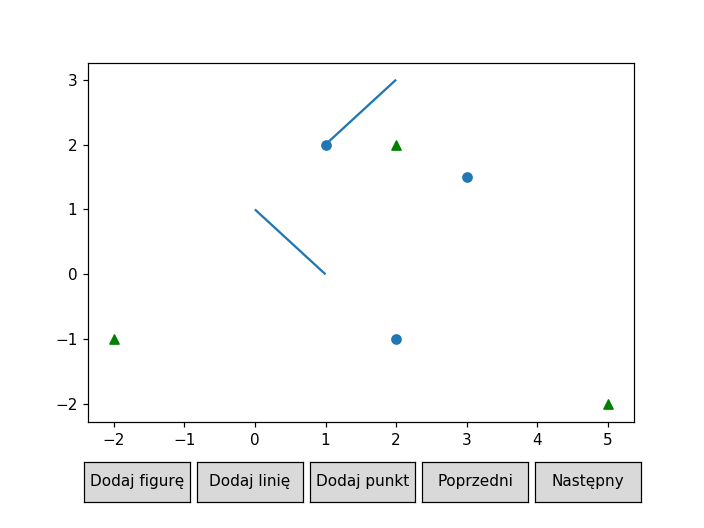

In [7]:


scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


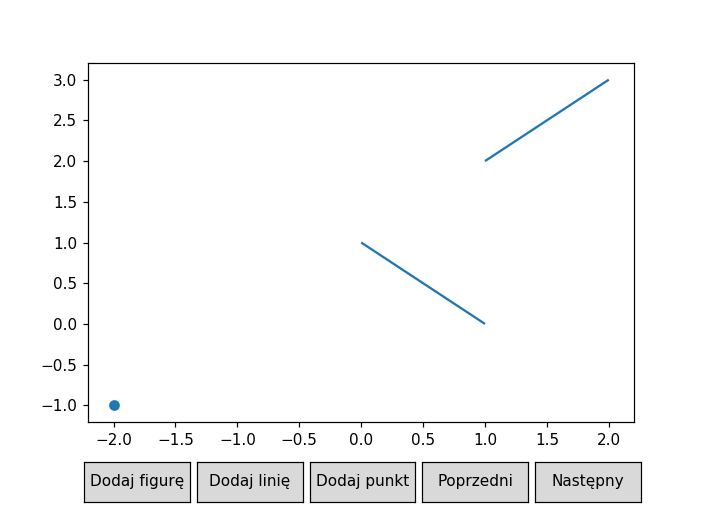

In [8]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
        
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


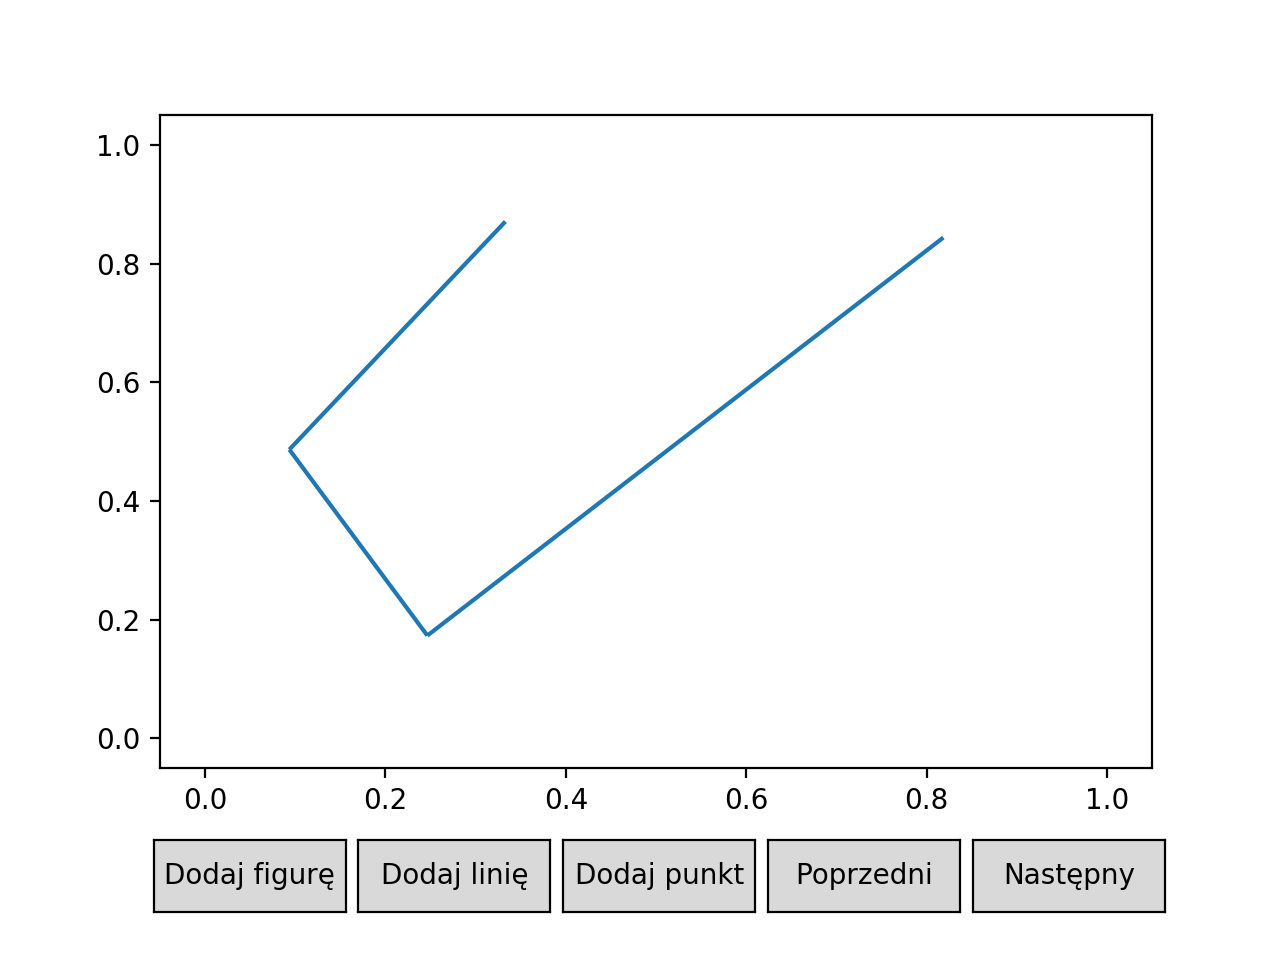

In [4]:
%matplotlib notebook
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


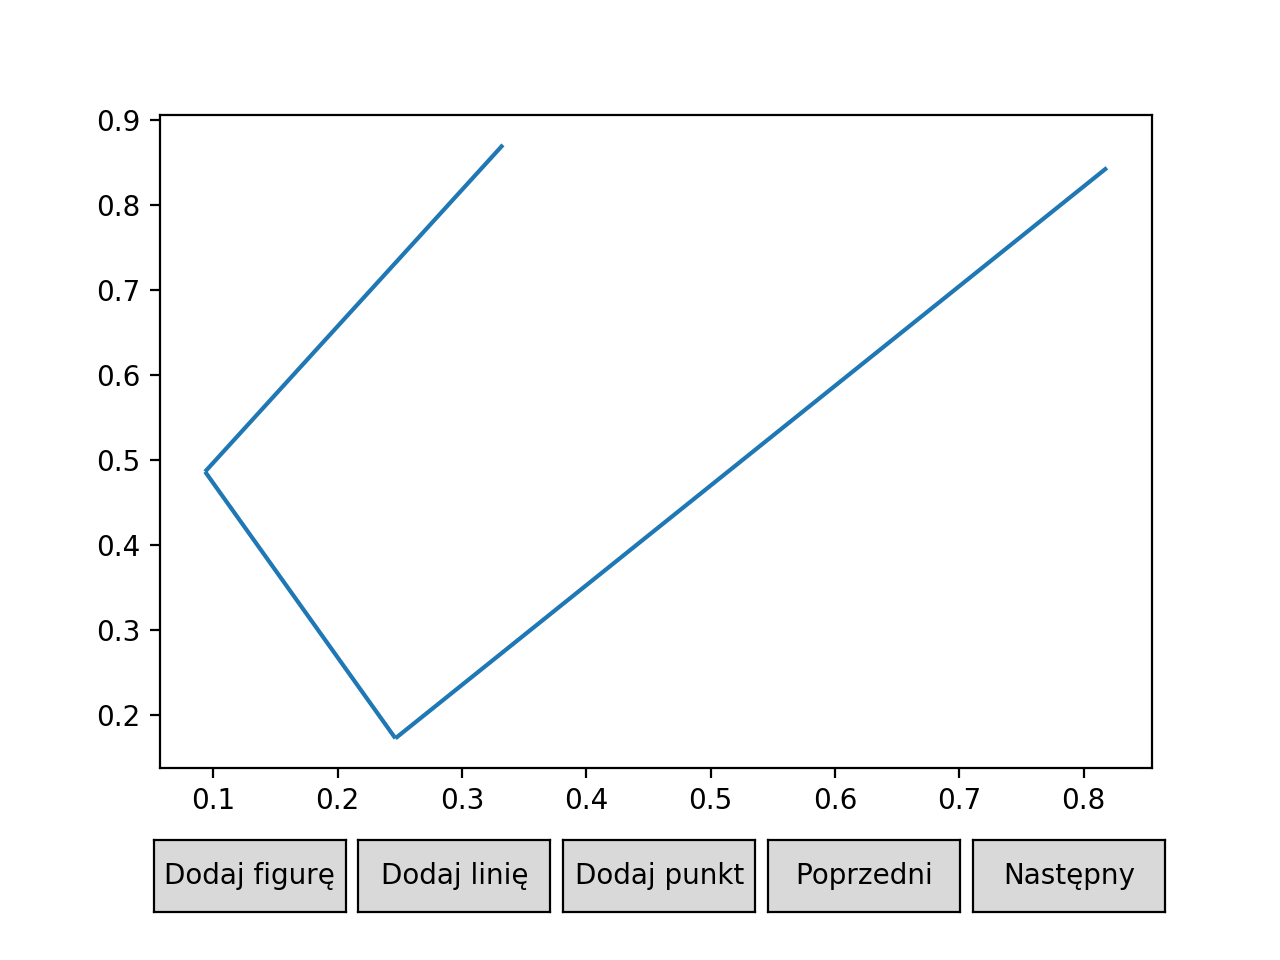

In [5]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

In [6]:
%matplotlib notebook


import numpy as np

<IPython.core.display.Javascript object>


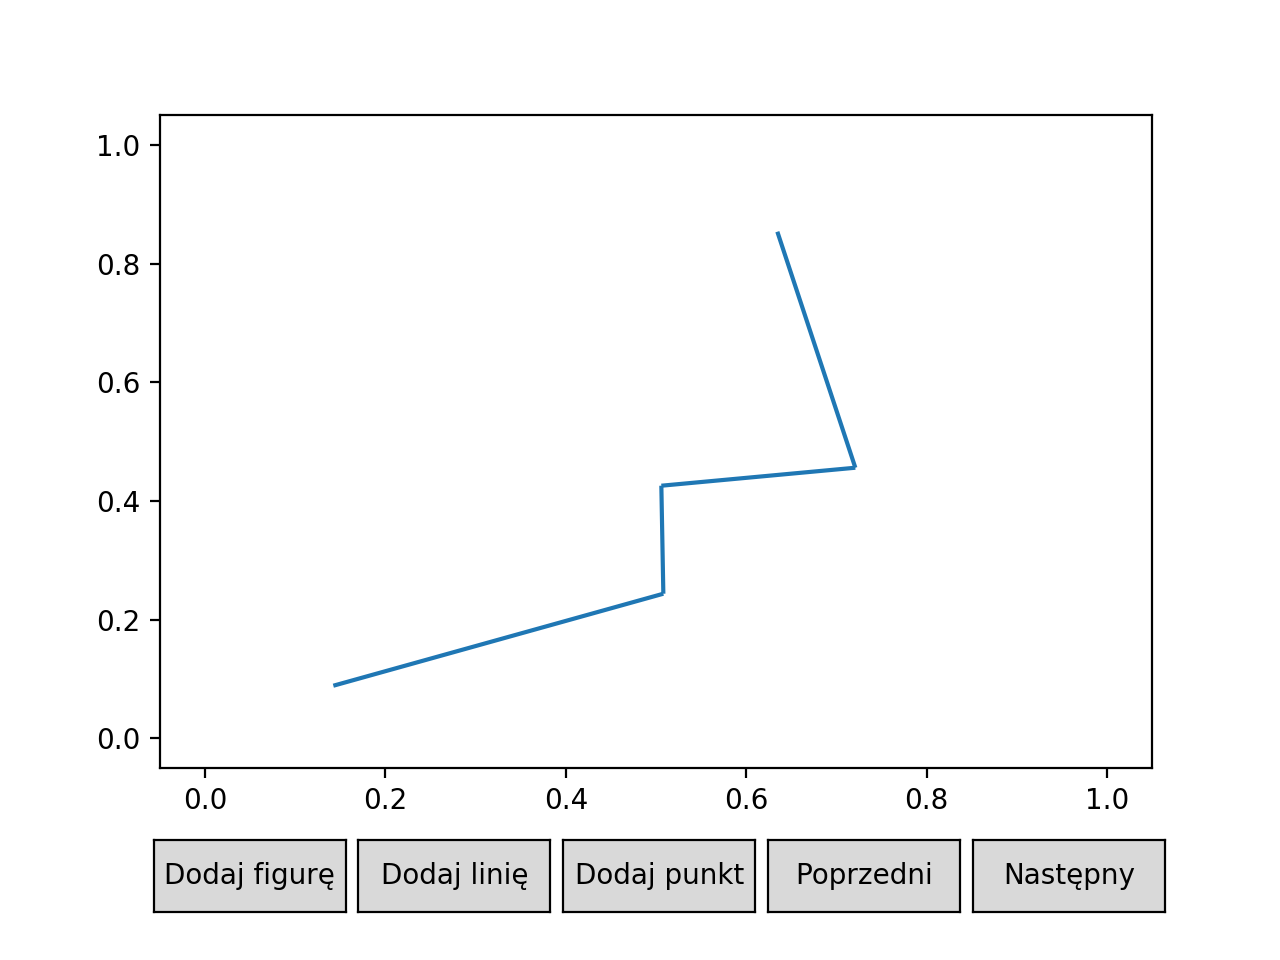

In [8]:
plotx = Plot()
plotx.draw()

In [9]:
import yaml
p = Plot([plotx.get_added_elements()])

with open('somefilex.json', 'w') as file:
    file.write(p.toJson())
    
with open('somefilex.json', 'r') as file:
    items = file.read()

items = items[1:-1]

items = yaml.load(items)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if sys.path[0] == '':


In [10]:
def get_chains(lines):
    
    direction = lines[0][0][1] < lines[0][1][1] # True up, False, down    
    counter = 0
    
    left_chain = []
    right_chain = []
            
    for l in lines:
        p0, p1 = l[0], l[1]
        
        if p0[1] < p1[1] and not direction:
            counter+=1
            direction = True
            
        elif p0[1] > p1[1] and direction:
            counter+=1
            direction = False
        
        if direction:
            right_chain.append([p0, p1])
        elif not direction:
            left_chain.append([p0, p1])
            
        if counter > 2:
            return [], []
        
    return left_chain, right_chain

<IPython.core.display.Javascript object>


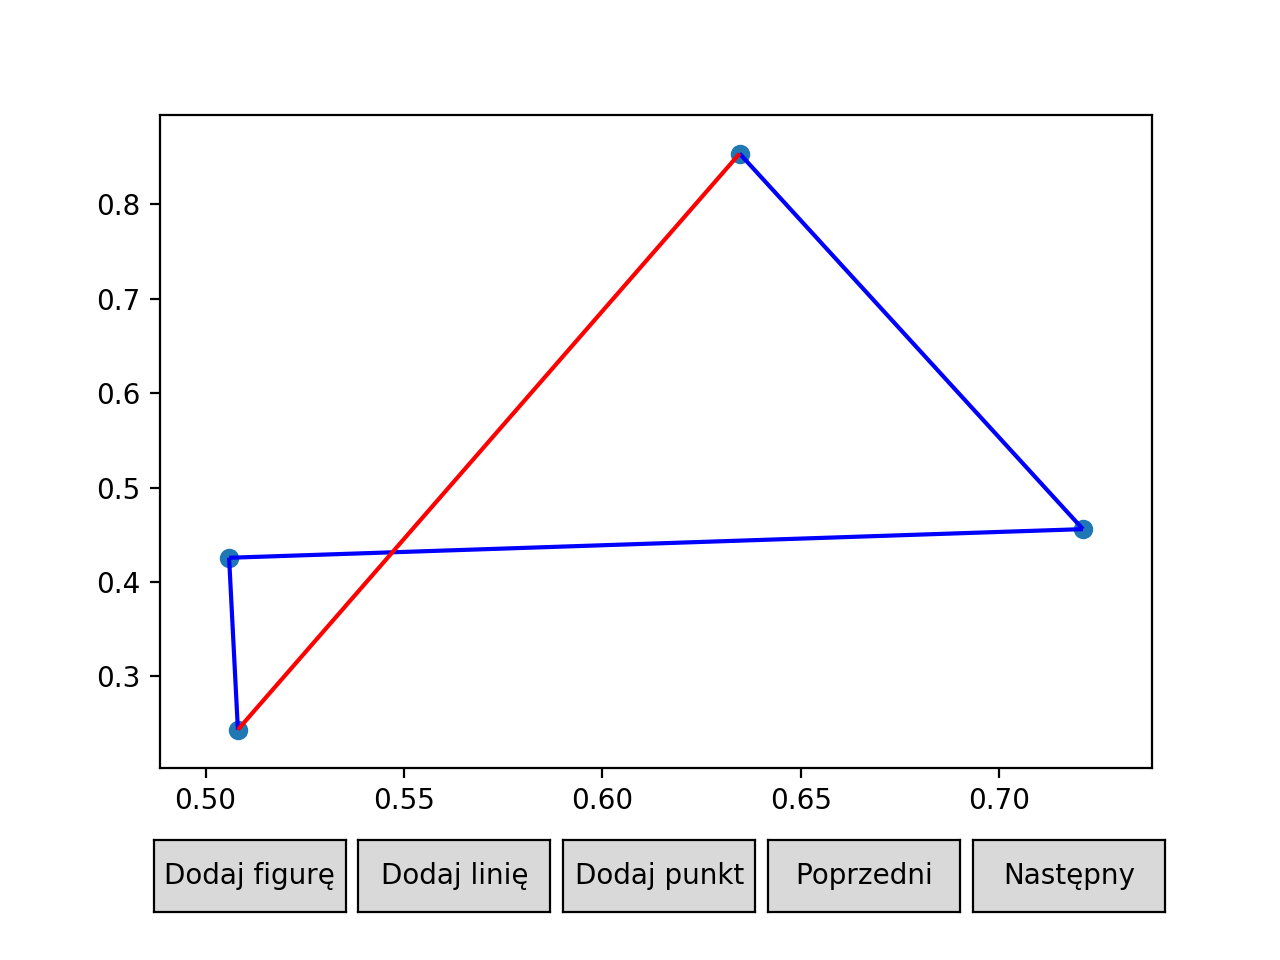

In [11]:
def get_points_from_lines(lines):
    points = set()
    for l in lines:
        points.add(tuple(l[0]))
        points.add(tuple(l[1]))
    
    return list(points)

lines = items['lines'][0][:-1]
lines.append([lines[-1][1], lines[0][0]])

points = get_points_from_lines(lines)
l_chain, r_chain = get_chains(lines)

plot = Plot([Scene([PointsCollection(points)], [LinesCollection(l_chain, color="blue"), LinesCollection(r_chain, color="red")])])

plot.draw()

In [178]:
def det(a,b,c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

#0 - beginning green, 1 - ending red, 2 - correct brown, 3 - connecting blue, 4 - dividing cyan
def ptype(p,prv,nxt):
        if (prv[1]-p[1])*(nxt[1]-p[1]) <= 0:
            return 2
        elif prv[1]-p[1] < 0 and nxt[1]-p[1] < 0 and det(prv,nxt,p) < 0:
            return 0
        elif prv[1]-p[1] > 0 and nxt[1]-p[1] > 0 and det(prv,nxt,p) < 0:
            return 1
        elif prv[1]-p[1] > 0 and nxt[1]-p[1] > 0 and det(prv,nxt,p) > 0:
            return 3  
        elif prv[1]-p[1] < 0 and nxt[1]-p[1] < 0 and det(prv,nxt,p) > 0:
            return 4
        

def color_by_type(points):
   
    d = {0 : [], 1 : [], 2 : [], 3 : [], 4 : []}
    
    p0, p1 = points[0], points[1]
    points.append(points[0])
    points.append(points[1])
    
    for p2 in points[2:]:
        res = ptype(p0, p1, p2)
        d[res].append(p1)
        p0 = p1
        p1 = p2
    
    return d[0], d[1], d[2], d[3], d[4]

In [171]:
beginning, ending, correct, connecting, dividing = color_by_type(points)

In [179]:
def color_points(beginning, ending, correct, connecting, diving):
    colors = {"beginning" : "green", 
              'ending' : 'red', 
              'correct' : 'brown', 
              'connecting' : 'blue', 
              'dividing' : 'cyan'}    
    p = [PointsCollection(beginning, color=colors['beginning'], alpha=1),
        PointsCollection(ending, color=colors['ending'], alpha=1),
        PointsCollection(correct, color=colors['correct'], alpha=1),
        PointsCollection(connecting, color=colors['correct'], alpha=1),
        PointsCollection(diving, color=colors['dividing'], alpha=1)]
    return p

<IPython.core.display.Javascript object>


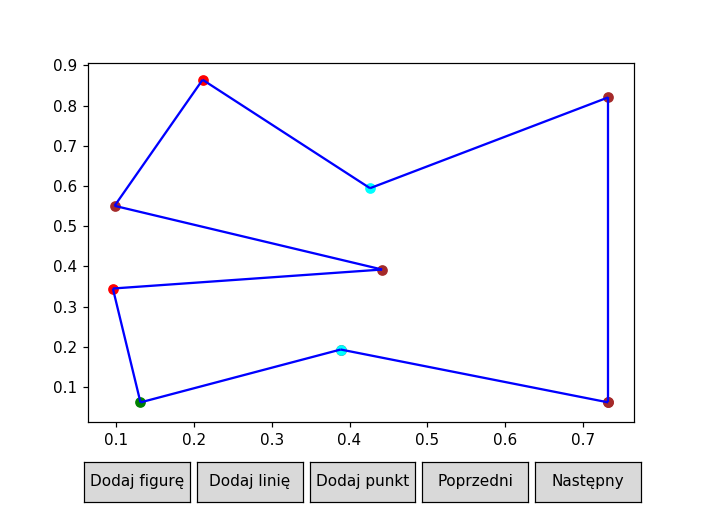

In [181]:
beg, end, cor, con, div = color_by_type(points)

plot = Plot([Scene(color_points(beg, end, cor, con, div), [LinesCollection(lines, color="blue")])])

plot.draw()